In [5]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import matplotlib.pyplot as plt 
from collections import deque 

from vehicle_model_DDQN_SOC_dev_norm import Environment 
from cell_model import CellModel 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [6]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_e-4wd_Battery.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_id_75_110_Westinghouse.mat"
cell_model = CellModel()
env = Environment(cell_model, drving_cycle, battery_path, motor_path, 1)


In [7]:
# STATE_SIZE = env.calculation_comp["state_size"]
STATE_SIZE = 4
ACTION_SIZE = env.calculation_comp["action_size"] 
LEARNING_RATE = 0.00025 

TOTAL_EPISODES = 200
MAX_STEPS = 50000 

GAMMA = 0.95 

MAX_EPSILON = 1 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
TAU = 0.001 
DELAY_TRAINING = 1000 
EPSILON_MIN_ITER = 5000

In [8]:
primary_network = keras.Sequential([
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()), 
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(ACTION_SIZE),
])
target_network = keras.Sequential([
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()), 
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#     keras.layers.BatchNormalization(), 
    keras.layers.Dense(ACTION_SIZE),
])

primary_network.compile(
    loss="mse", 
    optimizer=keras.optimizers.Adam(lr=LEARNING_RATE) 
)

# for t, p in zip(target_network.trainable_variables, primary_network.trainable_variables): 
#     t.assign(p)

In [9]:
def update_network(primary_network, target_network): 
    for t, p in zip(target_network.trainable_variables, primary_network.trainable_variables): 
        t.assign(t * (1 - TAU) + p * TAU)

In [10]:
class Memory: 
    def __init__(self, max_memory): 
        self.max_memory = max_memory 
        self._samples = [] 
        
    def add_sample(self, sample): 
        self._samples.append(sample)
        if len(self._samples) > self.max_memory: 
            self._samples.pop(0)
        
    def sample(self, no_samples): 
        if no_samples > len(self._samples): 
            return random.sample(self._samples, len(self._samples))
        else: 
            return random.sample(self._samples, no_samples)
    
    @property
    def num_samples(self):
        return len(self._samples)
    

# memory = Memory(10000)

In [11]:
def choose_action(state, primary_network, eps): 
    if random.random() < eps: 
        return random.randint(0, ACTION_SIZE - 1)
    else: 
        return np.argmax(primary_network(np.array(state).reshape(1, -1))) 

In [12]:
def train(primary_network, target_network, memory): 
    batch = memory.sample(BATCH_SIZE)
    states = np.array([val[0] for val in batch]) 
    actions = np.array([val[1] for val in batch])
    rewards = np.array([val[2] for val in batch])
    next_states = np.array([np.zeros(STATE_SIZE) if val[3] is None else val[3]  
                            for val in batch])
    
    prim_qt = primary_network(states)
    prim_qtp1 = primary_network(next_states)
    target_q = prim_qt.numpy() 
    updates = rewards 
    valid_idxs = next_states.sum(axis=1) != 0 
    batch_idxs = np.arange(BATCH_SIZE)
    prim_action_tp1 = np.argmax(prim_qtp1.numpy(), axis=1)
    q_from_target = target_network(next_states)
    updates[valid_idxs] += GAMMA * q_from_target.numpy()[batch_idxs[valid_idxs], 
                                                        prim_action_tp1[valid_idxs]]
    
    target_q[batch_idxs, actions] = updates 
    loss = primary_network.train_on_batch(states, target_q)
    return loss 
    
    
    

In [13]:
def initialization_with_rewardFactor(reward_factor):
    env = Environment(cell_model, drving_cycle, battery_path, motor_path, reward_factor)
    
    memory = Memory(10000)
    
    primary_network = keras.Sequential([
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#         keras.layers.BatchNormalization(),  
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#         keras.layers.BatchNormalization(), 
        keras.layers.Dense(ACTION_SIZE),
    ])
    target_network = keras.Sequential([
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()), 
#         keras.layers.BatchNormalization(), 
        keras.layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.he_normal()),
#         keras.layers.BatchNormalization(), 
        keras.layers.Dense(ACTION_SIZE),
    ])
    primary_network.compile(
        loss="mse", 
        optimizer=keras.optimizers.Adam(lr=LEARNING_RATE) 
    )
    return env, memory, primary_network, target_network 
    

In [14]:
print("environment version: {}".format(env.version)) 

 
reward_factors = [10]
results_dict = {} 

for reward_factor in reward_factors: 
    eps = MAX_EPSILON 
    steps = 0
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    
    env, memory, primary_network, target_network = initialization_with_rewardFactor(reward_factor)
    for episode in range(TOTAL_EPISODES): 
        state = env.reset() 
        avg_loss = 0 
        total_reward = 0
        cnt = 1 

        while True:
            action = choose_action(state, primary_network, eps)
            next_state, reward, done = env.step(action)
            total_reward += reward 
            if done: 
                next_state = None 
            memory.add_sample((state, action, reward, next_state))

            if steps > DELAY_TRAINING: 
                loss = train(primary_network, target_network, memory)
                update_network(primary_network, target_network)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * steps)
            else: 
                loss = -1

            avg_loss += loss 
            steps += 1 

            if done: 
                if steps > DELAY_TRAINING: 
                    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
                    avg_loss /= cnt 
                    print('Episode: {}'.format(episode + 1),
                          'Total reward: {}'.format(total_reward), 
                          'Explore P: {:.4f}'.format(eps), 
                          "SOC: {:.4f}".format(env.SOC), 
                         "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
                         "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
                         )
                else: 
                    print(f"Pre-training...Episode: {i}")
                
                episode_rewards.append(total_reward)
                episode_SOCs.append(env.SOC)
                episode_FCs.append(env.fuel_consumption)
                break 

            state = next_state 
            cnt += 1 
    
    results_dict[reward_factor] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs 
    }
            
    

environment version: 3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constru

maximum steps, simulation is done ... 
Episode: 40 Total reward: -526.666265231921 Explore P: 0.3401 SOC: 0.6669 Cumulative_SOC_deviation: 47.6882 Fuel Consumption: 49.7847
maximum steps, simulation is done ... 
Episode: 41 Total reward: -474.67383944789293 Explore P: 0.3311 SOC: 0.6322 Cumulative_SOC_deviation: 42.7387 Fuel Consumption: 47.2873
maximum steps, simulation is done ... 
Episode: 42 Total reward: -506.1486174728872 Explore P: 0.3224 SOC: 0.6599 Cumulative_SOC_deviation: 45.7018 Fuel Consumption: 49.1309
maximum steps, simulation is done ... 
Episode: 43 Total reward: -484.0218945682734 Explore P: 0.3140 SOC: 0.6782 Cumulative_SOC_deviation: 43.3489 Fuel Consumption: 50.5327
maximum steps, simulation is done ... 
Episode: 44 Total reward: -335.39782155803437 Explore P: 0.3057 SOC: 0.6292 Cumulative_SOC_deviation: 28.8544 Fuel Consumption: 46.8535
maximum steps, simulation is done ... 
Episode: 45 Total reward: -534.4235792912514 Explore P: 0.2977 SOC: 0.6541 Cumulative_SOC_

maximum steps, simulation is done ... 
Episode: 88 Total reward: -359.4948813846589 Explore P: 0.0983 SOC: 0.6072 Cumulative_SOC_deviation: 31.4466 Fuel Consumption: 45.0291
maximum steps, simulation is done ... 
Episode: 89 Total reward: -455.9313140329937 Explore P: 0.0960 SOC: 0.6092 Cumulative_SOC_deviation: 41.0316 Fuel Consumption: 45.6149
maximum steps, simulation is done ... 
Episode: 90 Total reward: -321.63726808321945 Explore P: 0.0936 SOC: 0.6067 Cumulative_SOC_deviation: 27.6688 Fuel Consumption: 44.9495
maximum steps, simulation is done ... 
Episode: 91 Total reward: -261.73567321924685 Explore P: 0.0914 SOC: 0.6094 Cumulative_SOC_deviation: 21.6359 Fuel Consumption: 45.3767
maximum steps, simulation is done ... 
Episode: 92 Total reward: -323.23006191584534 Explore P: 0.0892 SOC: 0.6055 Cumulative_SOC_deviation: 27.8283 Fuel Consumption: 44.9470
maximum steps, simulation is done ... 
Episode: 93 Total reward: -295.9296048987878 Explore P: 0.0870 SOC: 0.6073 Cumulative_SO

maximum steps, simulation is done ... 
Episode: 135 Total reward: -261.71110551215986 Explore P: 0.0343 SOC: 0.6044 Cumulative_SOC_deviation: 21.7023 Fuel Consumption: 44.6885
maximum steps, simulation is done ... 
Episode: 136 Total reward: -250.91495608640744 Explore P: 0.0336 SOC: 0.6042 Cumulative_SOC_deviation: 20.6061 Fuel Consumption: 44.8537
maximum steps, simulation is done ... 
Episode: 137 Total reward: -376.9395748464415 Explore P: 0.0330 SOC: 0.6033 Cumulative_SOC_deviation: 33.2112 Fuel Consumption: 44.8279
maximum steps, simulation is done ... 
Episode: 138 Total reward: -241.85417896026306 Explore P: 0.0324 SOC: 0.6046 Cumulative_SOC_deviation: 19.7179 Fuel Consumption: 44.6753
maximum steps, simulation is done ... 
Episode: 139 Total reward: -268.2520178140009 Explore P: 0.0318 SOC: 0.6024 Cumulative_SOC_deviation: 22.3204 Fuel Consumption: 45.0478
maximum steps, simulation is done ... 
Episode: 140 Total reward: -309.8075322912945 Explore P: 0.0312 SOC: 0.6038 Cumulat

maximum steps, simulation is done ... 
Episode: 182 Total reward: -287.95564647759767 Explore P: 0.0167 SOC: 0.6040 Cumulative_SOC_deviation: 24.3221 Fuel Consumption: 44.7351
maximum steps, simulation is done ... 
Episode: 183 Total reward: -262.1296909959366 Explore P: 0.0165 SOC: 0.6052 Cumulative_SOC_deviation: 21.7264 Fuel Consumption: 44.8659
maximum steps, simulation is done ... 
Episode: 184 Total reward: -303.79024453007355 Explore P: 0.0163 SOC: 0.6038 Cumulative_SOC_deviation: 25.8831 Fuel Consumption: 44.9596
maximum steps, simulation is done ... 
Episode: 185 Total reward: -307.82246799754864 Explore P: 0.0162 SOC: 0.6068 Cumulative_SOC_deviation: 26.2585 Fuel Consumption: 45.2378
maximum steps, simulation is done ... 
Episode: 186 Total reward: -297.47741032071553 Explore P: 0.0160 SOC: 0.6040 Cumulative_SOC_deviation: 25.2641 Fuel Consumption: 44.8360
maximum steps, simulation is done ... 
Episode: 187 Total reward: -301.14302975683944 Explore P: 0.0158 SOC: 0.6037 Cumul

TypeError: float() argument must be a string or a number, not 'dict'

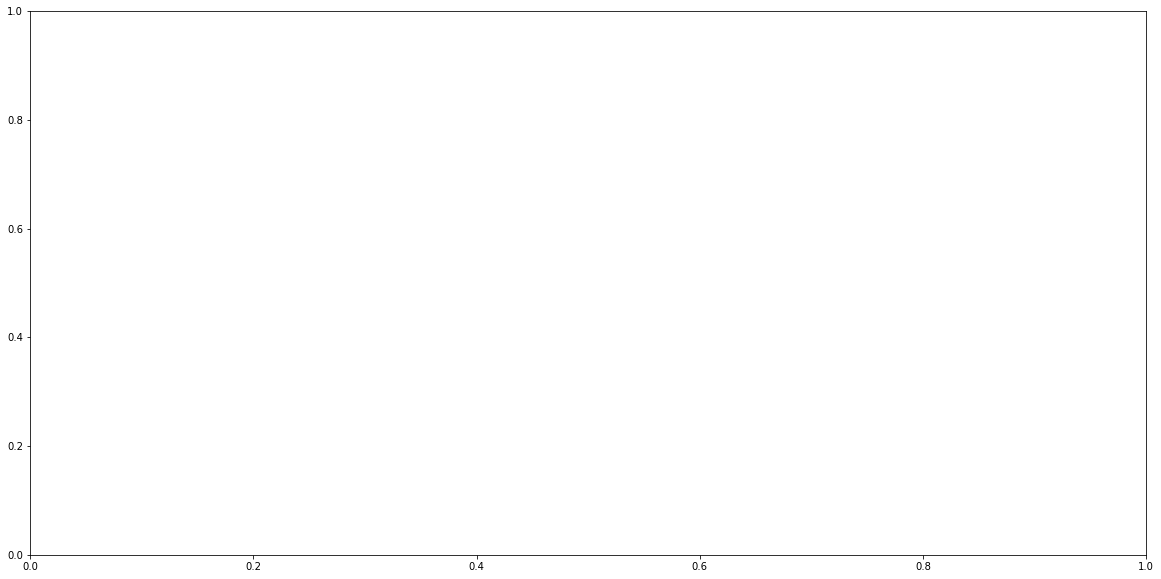

In [15]:
plt.figure(figsize=(20, 10))
for size, history in results_dict.items(): 
    plt.plot(history, label=size, linewidth=3.0) 


plt.grid() 
plt.legend(fontsize=20)
plt.xlabel("episode number", fontsize=20) 
plt.ylabel("total rewards", fontsize=20) 
plt.xlim([0, 120])


plt.savefig("replay_memory_size_effect_300.png")
with open("replay_memory_size_effect_300.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("results/replay_memory_size_effect.pkl", "rb") as f: 
    data = pickle.load(f)
    
data

In [ ]:
-(3 > 2) * 2
